In [17]:
#Importing dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Importing Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [20]:
# Creating engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\arjun\AppData\Local\Temp\ipykernel_33904\631302914.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [22]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [23]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [24]:
# Creating session from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
# Finding the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()
most_recent_date

('2017-08-23',)

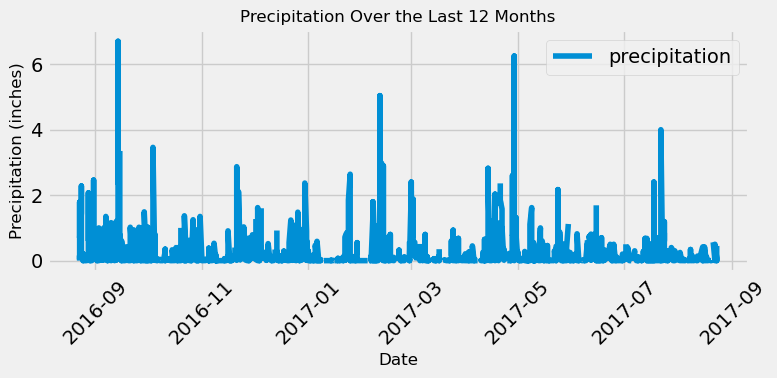

In [26]:
# Designing a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Calculating the date one year from the last date in data set.
one_year_ago = (pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')


# Perform a query to retrieve the data and precipitation scores.
precipitation_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago)  # Start from one year before 'most_recent_date'
    .order_by(Measurement.date)
    .all()
)

# Saving the query results as a Pandas DataFrame. 
precipitation_df = pd.DataFrame(precipitation_data, columns=["date", "precipitation"])


# Sorting the dataframe by date.
precipitation_df["date"] = pd.to_datetime(precipitation_df["date"])
precipitation_df = precipitation_df.sort_values("date")


# Use Pandas Plotting with Matplotlib to plot the data.
plt.figure(figsize=(8, 4))
plt.plot(precipitation_df["date"], precipitation_df["precipitation"], label="precipitation")
plt.title("Precipitation Over the Last 12 Months", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Precipitation (inches)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df['precipitation'] = pd.to_numeric(precipitation_df['precipitation'], errors='coerce')
 
# Handle missing values (we dropped the rows with missing precipitation values)
df = precipitation_df.dropna(subset=['precipitation'])
 
# Calculate the summary statistics
summary_stats = df['precipitation'].describe()
 
# Print the summary statistics
print(summary_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [28]:
# Designing a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [13]:
# Designing a query to find the most active stations.
# Listing the stations and their counts in descending order.
most_active_stations = (
    session.query(Measurement.station, func.count(Measurement.station).label('count'))
    .group_by(Measurement.station)
    .order_by(desc('count'))
    .all()
)

# Print the result as a list of tuples.
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Usinging the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]  

# Query to calculate the lowest, highest, and average temperature.
temperature_stats = (
    session.query(
        func.min(Measurement.tobs).label("min_temp"),
        func.max(Measurement.tobs).label("max_temp"),
        func.avg(Measurement.tobs).label("avg_temp")
    )
    .filter(Measurement.station == most_active_station_id)
    .one()
)

# Print the results.
print(f"Station: {most_active_station_id}")
print(f"Lowest Temperature: {temperature_stats.min_temp}°F")
print(f"Highest Temperature: {temperature_stats.max_temp}°F")
print(f"Average Temperature: {temperature_stats.avg_temp:.2f}°F")

Station: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


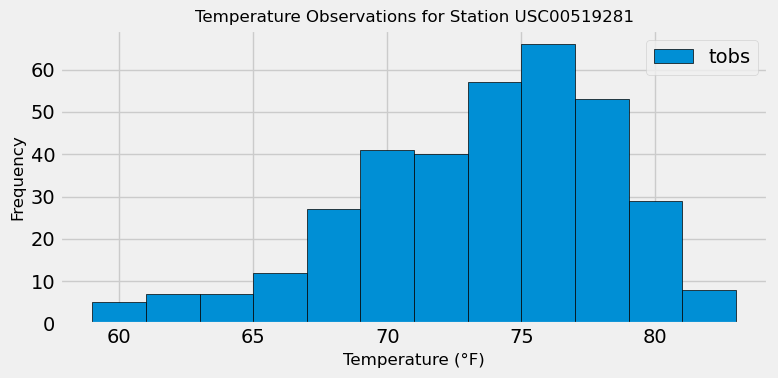

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = most_active_stations[0][0] 

# Calculating the date one year from the most recent date.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)

# Query the last 12 months of temperature observation data for the most active station.
temperature_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d'))
    .all()
)

# Convert the query results to a Pandas DataFrame.
temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])

# Plot the data as a histogram.
plt.figure(figsize=(8, 4))
plt.hist(temperature_df['tobs'], bins=12, edgecolor='black', label="tobs")
plt.title(f"Temperature Observations for Station {most_active_station_id}", fontsize=12)
plt.xlabel("Temperature (°F)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()